In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
from PIL import Image
import io

In [2]:
rnd_seed=24
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "6g")\
    .appName("Retinal-Disease-Classification").getOrCreate()
sc = spark.sparkContext
spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/25 23:02:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
train_path = '../Dataset/Training_Set/Training_Set/'
test_path = '../Dataset/Test_Set/Test_Set/'

target = "Disease_Risk"

In [5]:
train_label = spark.read.option("delimiter", ",").option("header", True)\
    .csv(train_path + 'RFMiD_Training_Labels.csv')

In [6]:
train_label.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Disease_Risk: string (nullable = true)
 |-- DR: string (nullable = true)
 |-- ARMD: string (nullable = true)
 |-- MH: string (nullable = true)
 |-- DN: string (nullable = true)
 |-- MYA: string (nullable = true)
 |-- BRVO: string (nullable = true)
 |-- TSLN: string (nullable = true)
 |-- ERM: string (nullable = true)
 |-- LS: string (nullable = true)
 |-- MS: string (nullable = true)
 |-- CSR: string (nullable = true)
 |-- ODC: string (nullable = true)
 |-- CRVO: string (nullable = true)
 |-- TV: string (nullable = true)
 |-- AH: string (nullable = true)
 |-- ODP: string (nullable = true)
 |-- ODE: string (nullable = true)
 |-- ST: string (nullable = true)
 |-- AION: string (nullable = true)
 |-- PT: string (nullable = true)
 |-- RT: string (nullable = true)
 |-- RS: string (nullable = true)
 |-- CRS: string (nullable = true)
 |-- EDN: string (nullable = true)
 |-- RPEC: string (nullable = true)
 |-- MHL: string (nullable = true)
 |-- RP: str

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def get_filename_from_origin(path):
    filename = path.split("/")[-1].split(".")
    return filename[0] if len(filename) < 2 else "".join(filename[:-1])

filenameUDF = udf(lambda path: get_filename_from_origin(path), StringType())

In [8]:
def get_extension_from_origin(path):
    return path.split("/")[-1].split(".")[-1]

extensionUDF = udf(lambda path: get_extension_from_origin(path), StringType())

In [9]:
from pyspark.sql.functions import input_file_name

train_images = spark.read.format('binaryFile')\
    .option("pathGlobFilter", "*.png")\
    .option("dropInvalid", True).load(train_path + '/Training/')\
    .withColumn('filename', filenameUDF(input_file_name()))\
    .withColumn('extension', extensionUDF(input_file_name()))\
    .select('filename', 'extension', 'content', 'length', 'path')

In [10]:
train_df = train_images.join(train_label, train_images.filename == train_label.ID, "inner")\
    .select('ID', 'filename', 'extension', 'content', 'length', 'path', target).cache()

train_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- extension: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- length: long (nullable = true)
 |-- path: string (nullable = true)
 |-- Disease_Risk: string (nullable = true)



In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [12]:
model = ResNet50(include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [13]:
bc_model_weights = sc.broadcast(model.get_weights())

In [14]:
def model_fn():
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [15]:
def preprocess(content, resize=(224, 224)):
    img = Image.open(io.BytesIO(content)).resize(resize)
    arr = img_to_array(img)
    return preprocess_input(arr)

In [16]:
def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [17]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [19]:
from pyspark.sql.functions import col

features_train = train_df.repartition(16)\
    .select(col("path"), 
            col(target).alias('Target'),
            featurize_udf("content").alias("features"))

train_df.unpersist()

DataFrame[ID: string, filename: string, extension: string, content: binary, length: bigint, path: string, Disease_Risk: string]

In [20]:
from pyspark.ml.linalg import Vectors, VectorUDT

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [21]:
features_train = features_train\
    .select(col('path'), col('Target'),
            list_to_vector_udf(features_train["features"]).alias("features"),).cache()

features_train.printSchema()

root
 |-- path: string (nullable = true)
 |-- Target: string (nullable = true)
 |-- features: vector (nullable = true)



In [22]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

vectorAssembler = VectorAssembler(inputCols=['features'], outputCol="featuresModel")
labelIndexer = StringIndexer(inputCol="Target", outputCol="indexedTarget").fit(features_train)

In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=5, regParam=0.03, 
                        elasticNetParam=0.5, labelCol="indexedTarget", featuresCol="featuresModel")

sparkdn = Pipeline(stages=[labelIndexer,vectorAssembler,lr])

In [24]:
spark_model = sparkdn.fit(features_train)

22/05/25 23:23:57 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/05/25 23:24:14 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/05/25 23:24:18 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/05/25 23:24:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/25 23:24:25 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/25 23:24:39 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/05/25 23:24:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/25 23:24:41 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/05/25 23:24:42 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/05/25 23:24:47 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/05/25 23:24:48 WARN DAGS

In [25]:
test_label = spark.read.option("delimiter", ",").option("header", True)\
    .csv(test_path + 'RFMiD_Testing_Labels.csv')
    
test_images = spark.read.format('binaryFile')\
    .option("pathGlobFilter", "*.png")\
    .option("dropInvalid", True).load(test_path + '/Test/')\
    .withColumn('filename', filenameUDF(input_file_name()))\
    .withColumn('extension', extensionUDF(input_file_name()))\
    .select('filename', 'extension', 'content', 'length', 'path')
    
test_df = test_images.join(test_label, test_images.filename == test_label.ID, "inner")\
    .select('ID', 'filename', 'extension', 'content', 'length', 'path', target)
    
features_test = test_df.repartition(16)\
    .select(col("path"), 
            col(target).alias('Target'),
            featurize_udf("content").alias("features"))
    
features_test = features_test\
    .select(col('path'), col('Target'),
            list_to_vector_udf(features_test["features"]).alias("features"),).cache()

In [26]:
predictions = spark_model.transform(features_test)
predictions.printSchema()

root
 |-- path: string (nullable = true)
 |-- Target: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- indexedTarget: double (nullable = false)
 |-- featuresModel: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [27]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [28]:
pred = predictions.select('indexedTarget', 'prediction')\
        .rdd.map(lambda x: (x.indexedTarget, x.prediction))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under ROC : 0.8410759990225206


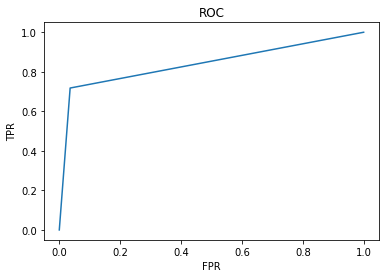

In [29]:
import matplotlib.pyplot as plt

metric = CurveMetrics(pred)
points = metric.get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)

print(f"Area under ROC : { metric.areaUnderROC }")

In [30]:
from pyspark.mllib.evaluation import MulticlassMetrics

pos_indx = float(labelIndexer.labels.index('1'))
metric = MulticlassMetrics(pred)
ACC = metric.accuracy
PRE = metric.precision(pos_indx)
REC = metric.recall(pos_indx)
F1 = metric.fMeasure(pos_indx)
print(f'Accuracy : {ACC}')
print(f'Precision : {PRE}')
print(f'Recall : {REC}')
print(f'F-1 : {F1}')

Accuracy : 0.9015625
Precision : 0.9090909090909091
Recall : 0.9643605870020965
F-1 : 0.935910478128179


In [31]:
model_path = '../Model/RN50_LR/' + target
spark_model.write().overwrite().save(model_path)